In [1]:
# Comparison of SCENT single-cell multiome cell type - peak pairs with Onek1k eQTL eGene-eSNP pairs
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib_venn as venn
import numpy as np
import pybedtools
from scipy.stats import false_discovery_control, fisher_exact
from scipy.stats.contingency import odds_ratio

pd.set_option('display.max_columns', None)

## Load and compare gene lists queried

In [2]:
b_celltypes = ["bin", "bmem", "plasma"]
tnk_celltypes = ["cd4nc", "cd4et", "cd8nc", "cd8et", "cd8s100b", "cd4sox4", "nk", "nkr"]
myeloid_celltypes = ["monoc", "mononc", "dc"]

In [3]:
scent_genelist = pd.read_csv("../SCENT/GeneBody_500kb_margin.bed", header=None, sep="\t", index_col=False, names=["chr", "cis_start", "cis_end", "gene"])

onek1k_genelists = {}
with open("../onek1k/onek1k_genelist.csv", "r") as f:
    lines = f.readlines()
    celltypes = lines[0][1:].strip().replace(" ", "").lower().split(",")
    for celltype in celltypes + ["Bcell", "Tnk", "Myeloid"]:
        onek1k_genelists[celltype] = set()
    print(celltypes)
    for line in lines[1:]:
        genes = line.strip().split(",")
        for i, gene in enumerate(genes):
            if gene == "": continue
            onek1k_genelists[celltypes[i]].add(gene)
for ct in b_celltypes:
    onek1k_genelists["Bcell"] = onek1k_genelists["Bcell"] | onek1k_genelists[ct]
for ct in tnk_celltypes:
    onek1k_genelists["Tnk"] = onek1k_genelists["Tnk"] | onek1k_genelists[ct]
for ct in myeloid_celltypes:
    onek1k_genelists["Myeloid"] = onek1k_genelists["Myeloid"] | onek1k_genelists[ct]

['cd4nc', 'cd4et', 'cd4sox4', 'cd8et', 'cd8nc', 'cd8s100b', 'nk', 'nkr', 'plasma', 'bmem', 'bin', 'monoc', 'mononc', 'dc']


In [4]:
scent_geneset = set(scent_genelist["gene"])
genes_intersect_count = {}
for k, v in onek1k_genelists.items():
    print(k, " "*(10-len(k)),len(v & scent_geneset))
    genes_intersect_count[k] = len(v & scent_geneset)

cd4nc       12030
cd4et       10233
cd4sox4     5797
cd8et       11205
cd8nc       11077
cd8s100b    9573
nk          11096
nkr         7949
plasma      6572
bmem        9978
bin         10321
monoc       9902
mononc      8961
dc          8763
Bcell       10473
Tnk         12247
Myeloid     10171


## Load data, compare and match cell types

In [5]:
enhancers = glob("../outputs/onek1k_enhancers_fdr0.1/*")
onek1k_enhancers = []
for e in enhancers:
    temp = pd.read_csv(e, usecols=["CELL_ID", "RSID", "SNPID", "GENE", "chr_x", "start", "region", "NEW_Q", "cis_start", "cis_end"])
    temp["gene_set_intersect"] = int(e.split("_")[-1][:-9])
    onek1k_enhancers.append(temp)
onek1k = pd.concat(onek1k_enhancers)
onek1k

,CELL_ID,RSID,SNPID,GENE,chr_x,start,region,cis_start,cis_end,NEW_Q,gene_set_intersect
0,bin,rs7544660,1:1124343_T,MRPL20,chr1,1188963,chr1:1188963,901908,1907293,0.098893,10312
1,bin,rs139541693,1:1125423_T,MRPL20,chr1,1190043,chr1:1190043,901908,1907293,0.098893,10312
2,bin,rs72894023,1:1125774_G,MRPL20,chr1,1190394,chr1:1190394,901908,1907293,0.098893,10312
3,bin,rs9727406,1:1126087_T,MRPL20,chr1,1190707,chr1:1190707,901908,1907293,0.098893,10312
4,bin,rs9730380,1:1127010_A,MRPL20,chr1,1191630,chr1:1191630,901908,1907293,0.098893,10312
...,...,...,...,...,...,...,...,...,...,...,...
309322,cd8nc,rs5770821,22:51150771_G,ARSA,chr22,50712343,chr22:50712343,50122753,51128173,0.000335,11068
309323,cd8nc,rs6009951,22:51151350_T,ARSA,chr22,50712922,chr22:50712922,50122753,51128173,0.000705,11068
309324,cd8nc,rs9616947,22:51151631_T,ARSA,chr22,50713203,chr22:50713203,50122753,51128173,0.000574,11068
309325,cd8nc,rs6010061,22:51151724_T,ARSA,chr22,50713296,chr22:50713296,50122753,51128173,0.000733,11068


In [6]:
scent = pd.read_csv("../SCENT/Pubic-PBMC_allqced_bootpkg_nopc_allCT.FDR0.10.txt.gz", sep="\t", compression="gzip")
scent[["chr", "pos_start", "pos_end"]] = scent["peak"].str.split("-", expand=True)
scent.head()

,gene,peak,beta,se,z,p,boot_p,fdr,celltype,chr,pos_start,pos_end
0,ABL2,chr1-178867358-178867980,0.810490,0.193249,4.194015,2.740598e-05,0.00004,0.016217,Bcell,chr1,178867358,178867980
1,ABLIM1,chr10-114540798-114541777,0.715291,0.110496,6.473457,9.578577e-11,0.00004,0.016217,Bcell,chr10,114540798,114541777
2,ABR,chr17-1576741-1577977,0.465925,0.114801,4.058540,4.938037e-05,0.00012,0.038722,Bcell,chr17,1576741,1577977
3,ABT1,chr6-26607255-26607921,1.011734,0.279898,3.614655,3.007477e-04,0.00004,0.016217,Bcell,chr6,26607255,26607921
4,ACAD10,chr12-112075309-112076176,0.937681,0.230274,4.072029,4.660535e-05,0.00008,0.028125,Bcell,chr12,112075309,112076176


In [7]:
print(scent.value_counts(["celltype"]))

onek1k.value_counts(["CELL_ID"])

celltype
Tnk         7936
Myeloid     7403
Bcell       1235
Name: count, dtype: int64


CELL_ID 
cd4nc       642112
nk          401822
cd8et       380121
cd8nc       309327
bin         229853
cd4et       217717
bmem        214211
cd8s100b    160190
monoc       157518
mononc      152803
dc          129508
nkr         109508
cd4sox4     107361
plasma       96687
Name: count, dtype: int64

In [8]:
onek1k["matched_celltype"] = np.select(
    [
        onek1k["CELL_ID"].isin(tnk_celltypes),
        onek1k["CELL_ID"].isin(b_celltypes),
        onek1k["CELL_ID"].isin(myeloid_celltypes)
    ],
    [
        "Tnk",
        "Bcell",
        "Myeloid",
    ],
    default="None"
)

In [9]:
onek1k_1 = onek1k.drop_duplicates(subset=onek1k.columns[1:9].tolist() + ["matched_celltype"]) # disregard fine cell types
onek1k_1.index = np.arange(1, len(onek1k_1)+1)
onek1k_1

,CELL_ID,RSID,SNPID,GENE,chr_x,start,region,cis_start,cis_end,NEW_Q,gene_set_intersect,matched_celltype
1,bin,rs7544660,1:1124343_T,MRPL20,chr1,1188963,chr1:1188963,901908,1907293,0.098893,10312,Bcell
2,bin,rs139541693,1:1125423_T,MRPL20,chr1,1190043,chr1:1190043,901908,1907293,0.098893,10312,Bcell
3,bin,rs72894023,1:1125774_G,MRPL20,chr1,1190394,chr1:1190394,901908,1907293,0.098893,10312,Bcell
4,bin,rs9727406,1:1126087_T,MRPL20,chr1,1190707,chr1:1190707,901908,1907293,0.098893,10312,Bcell
5,bin,rs9730380,1:1127010_A,MRPL20,chr1,1191630,chr1:1191630,901908,1907293,0.098893,10312,Bcell
...,...,...,...,...,...,...,...,...,...,...,...,...
1722835,cd8nc,rs56926656,22:51055968_A,CHKB,chr22,50617540,chr22:50617540,50078948,51101455,0.051616,11068,Tnk
1722836,cd8nc,rs5771056,22:50930802_G,ARSA,chr22,50492373,chr22:50492373,50122753,51128173,0.096376,11068,Tnk
1722837,cd8nc,rs5771060,22:50932563_T,ARSA,chr22,50494134,chr22:50494134,50122753,51128173,0.045356,11068,Tnk
1722838,cd8nc,rs62239506,22:50974438_A,ARSA,chr22,50536009,chr22:50536009,50122753,51128173,0.069140,11068,Tnk


## Compare gene and SNP/peak coverage

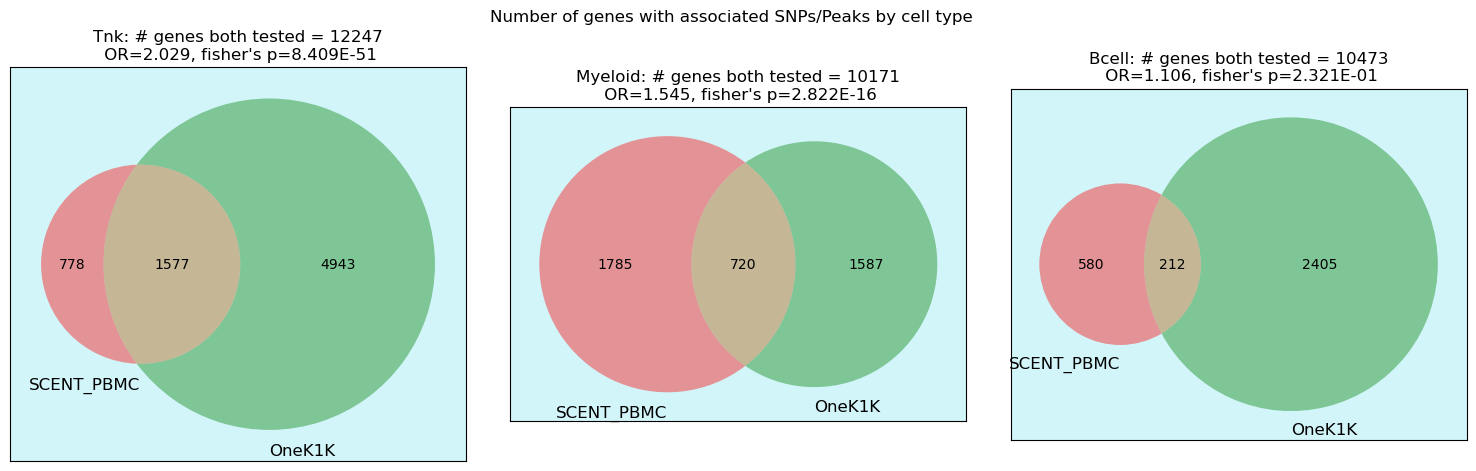

In [10]:
# gene set by cell type
fdr_thres = 0.1
onek1k_fdr = onek1k[onek1k["NEW_Q"]< fdr_thres]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Number of genes with associated SNPs/Peaks by cell type")
for i, ctype in enumerate(["Tnk", "Myeloid", "Bcell"]):
    scent_gs = set(scent[scent["celltype"]==ctype]["gene"]) & onek1k_genelists[ctype]
    onek1k_gs = set(onek1k_fdr[onek1k_fdr["matched_celltype"]==ctype]["GENE"])
    venn.venn2((
        scent_gs, onek1k_gs
    ), set_labels=("SCENT_PBMC", "OneK1K"), ax=axs[i])
    table = np.array([
        [len(scent_gs & onek1k_gs), len(scent_gs - onek1k_gs)],
        [len(onek1k_gs - scent_gs), genes_intersect_count[ctype] - len(scent_gs | onek1k_gs)]
    ])
    OR, fisherp = fisher_exact(table)
    axs[i].set_title(f"{ctype}: # genes both tested = {genes_intersect_count[ctype]}\n OR={OR:.3f}, fisher's p={fisherp:.3E}")
    axs[i].set_facecolor('#d2f5fa')
    axs[i].set_axis_on()
plt.tight_layout()
plt.show()

In [11]:
start_fdr = 0.1
fdrs = []
ors = {"Tnk":[], "Myeloid":[], "Bcell":[]}
fisher_ps = {"Tnk":[], "Myeloid":[], "Bcell":[]}
for j in range(20):
    onek1k_fdr = onek1k[onek1k["NEW_Q"]< start_fdr]
    for i, ctype in enumerate(["Tnk", "Myeloid", "Bcell"]):
        scent_gs = set(scent[scent["celltype"]==ctype]["gene"]) & onek1k_genelists[ctype]
        onek1k_gs = set(onek1k_fdr[onek1k_fdr["matched_celltype"]==ctype]["GENE"])
        table = np.array([
            [len(scent_gs & onek1k_gs), len(scent_gs - onek1k_gs)],
            [len(onek1k_gs - scent_gs), genes_intersect_count[ctype] - len(scent_gs | onek1k_gs)]
        ])
        OR, fisherp = fisher_exact(table)
        ors[ctype].append(OR)
        fisher_ps[ctype].append(fisherp)
    fdrs.append(start_fdr)
    start_fdr /= 2

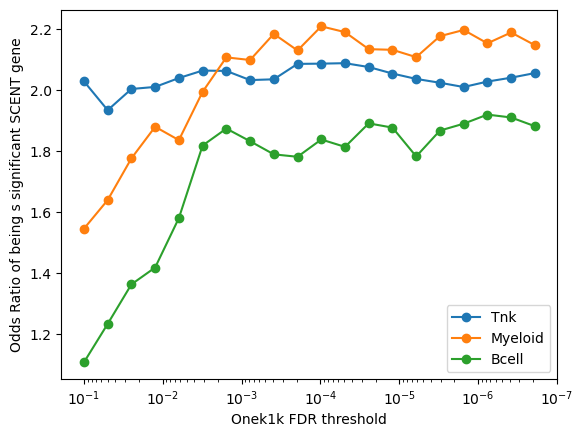

In [12]:
for ctype in ors:
    plt.plot(fdrs, ors[ctype], 'o-', label=ctype)
plt.xscale("log")
plt.gca().invert_xaxis()
plt.xlabel("Onek1k FDR threshold")
plt.ylabel("Odds Ratio of being s significant SCENT gene")
plt.legend()
plt.show()

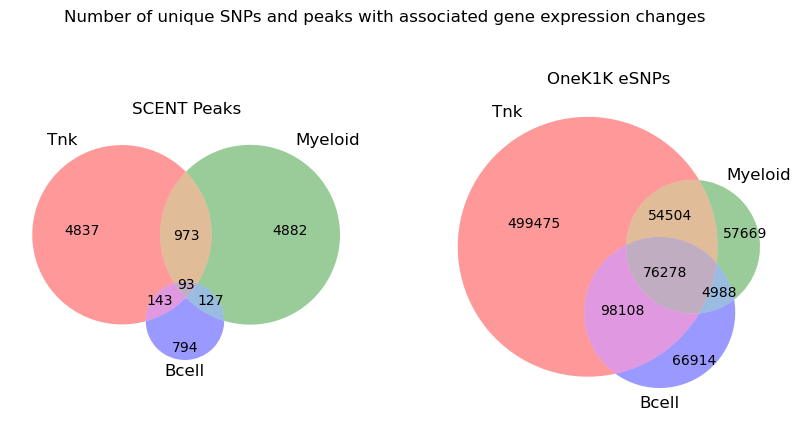

In [13]:
# number of unique SNPs and peaks associated with gene expression changes
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Number of unique SNPs and peaks with associated gene expression changes")
celltypes = ["Tnk", "Myeloid", "Bcell"]
venn.venn3(
    list(set(scent[scent["celltype"]==a]["peak"]) for a in celltypes), 
    set_labels=celltypes, ax=axs[0]
)
axs[0].set_title("SCENT Peaks")

venn.venn3(
    list(set(onek1k_1[onek1k_1["matched_celltype"]==a]["RSID"]) for a in celltypes), 
    set_labels=celltypes, ax=axs[1]
)
axs[1].set_title("OneK1K eSNPs")
plt.show()

## enhancer-gene pair overlaps

In [14]:
onek1k_1 = onek1k.sort_values(
    by=["CELL_ID", "GENE", "RSID", "NEW_Q"]
).drop_duplicates(subset=["CELL_ID", "GENE", "RSID"])
dup_count = onek1k.groupby(["CELL_ID", "GENE", "RSID"])["SNPID"].count().reset_index().rename(columns={"SNPID": "dup_count"})
onek1k_1 = onek1k_1.merge(dup_count, how="left", on=["CELL_ID", "GENE", "RSID"])
onek1k_1

,CELL_ID,RSID,SNPID,GENE,chr_x,start,region,cis_start,cis_end,NEW_Q,gene_set_intersect,matched_celltype,dup_count
0,bin,rs1005050,19:58949579_T,A1BG,chr19,58438212,chr19:58438212,57845177,58853492,0.003697,10312,Bcell,1
1,bin,rs10416149,19:58964306_G,A1BG,chr19,58452939,chr19:58452939,57845177,58853492,0.094013,10312,Bcell,1
2,bin,rs10417092,19:58915193_A,A1BG,chr19,58403826,chr19:58403826,57845177,58853492,0.003697,10312,Bcell,1
3,bin,rs1077420,19:58968875_C,A1BG,chr19,58457508,chr19:58457508,57845177,58853492,0.077198,10312,Bcell,1
4,bin,rs1107399,19:58955556_G,A1BG,chr19,58444189,chr19:58444189,57845177,58853492,0.002984,10312,Bcell,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2850015,plasma,rs9380069,6:28203300_G,ZSCAN16,chr6,28235522,chr6:28235522,27624608,28630082,0.059166,6567,Bcell,1
2850016,plasma,rs9393908,6:28190830_A,ZSCAN16,chr6,28223052,chr6:28223052,27624608,28630082,0.088128,6567,Bcell,1
2850017,plasma,rs9461432,6:28086883_C,ZSCAN16,chr6,28119105,chr6:28119105,27624608,28630082,0.092826,6567,Bcell,1
2850018,plasma,rs9468300,6:28126840_T,ZSCAN16,chr6,28159062,chr6:28159062,27624608,28630082,0.092826,6567,Bcell,1


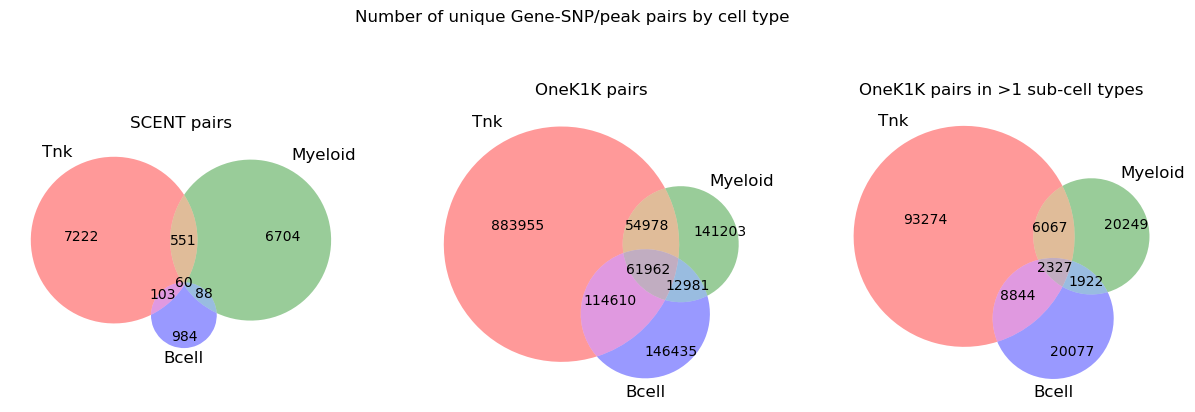

In [15]:
# check pairs
scent["pairs"] = scent["gene"] + "-" + scent["peak"]
# onek1k_1 = onek1k_1.copy()
onek1k_1["pairs"] = onek1k_1["GENE"] + "-" + onek1k_1["SNPID"]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Number of unique Gene-SNP/peak pairs by cell type")
venn.venn3(
    list(set(scent[scent["celltype"]==a]["pairs"]) for a in celltypes), 
    set_labels=celltypes, ax=axs[0]
)
axs[0].set_title("SCENT pairs")

venn.venn3(
    list(set(onek1k_1[onek1k_1["matched_celltype"]==a]["pairs"]) for a in celltypes), 
    set_labels=celltypes, ax=axs[1]
)
axs[1].set_title("OneK1K pairs")
venn.venn3(
    list(set(onek1k_1[(onek1k_1["matched_celltype"]==a) & (onek1k_1["dup_count"] > 1)]["pairs"]) for a in celltypes), 
    set_labels=celltypes, ax=axs[2]
)
axs[2].set_title("OneK1K pairs in >1 sub-cell types")
plt.show()

In [101]:
# onek1k_1.to_csv("processed_onek1k_enhancers.csv")

In [102]:
def get_num_matched_snps(row, onek1k_df):
    # print(row.index, flush=True)
    chr_pos = np.array(onek1k_df[
        (onek1k_df["matched_celltype"] == row["celltype"]) &
        (onek1k_df["GENE"] == row["gene"]) & 
        (onek1k_df["chr_x"] == row["chr"])
    ]["start"].tolist())
    return ((chr_pos >= int(row["pos_start"])) & (chr_pos <= int(row["pos_end"]))).sum()

In [20]:
onek1k_1.shape

(2850020, 14)

In [25]:
onek1k_scent = onek1k.merge(
    scent[["celltype", "gene", "chr", "pos_start", "pos_end"]], 
    how="inner", 
    left_on=["matched_celltype", "GENE", "chr_x"], 
    right_on=["celltype", "gene", "chr"]
)

In [26]:
onek1k_scent["pos_start"] = onek1k_scent["pos_start"].astype(int)
onek1k_scent["pos_end"] = onek1k_scent["pos_end"].astype(int)
onek1k_scent["match"] = (onek1k_scent["start"] >= onek1k_scent["pos_start"]) & (onek1k_scent["start"] <= onek1k_scent["pos_end"])

In [27]:
onek1k_scent.shape

(3652540, 18)

In [29]:
onek1k_scent.to_csv("../outputs/onek1k_scent_matched.csv", index=False)

In [28]:
onek1k_scent_match = onek1k_scent[onek1k_scent["match"]]
onek1k_scent_match

,CELL_ID,RSID,SNPID,GENE,chr_x,start,region,cis_start,cis_end,NEW_Q,gene_set_intersect,matched_celltype,celltype,gene,chr,pos_start,pos_end,match
1178,bin,rs12568320,1:157744004_G,FCRL5,chr1,157774214,chr1:157774214,157013376,158052515,7.799335e-04,10312,Bcell,Bcell,FCRL5,chr1,157773551,157774304,True
2235,plasma,rs1846416,1:167905411_A,RCSD1,chr1,167936173,chr1:167936173,167130092,168208696,4.769843e-02,6567,Bcell,Bcell,RCSD1,chr1,167935045,167937615,True
5221,bin,rs13008811,2:54982893_A,EML6,chr2,54755756,chr2:54755756,54223498,55472025,4.131918e-02,10312,Bcell,Bcell,EML6,chr2,54755669,54756222,True
5543,bmem,rs13008811,2:54982893_A,EML6,chr2,54755756,chr2:54755756,54223498,55472025,9.372850e-03,9970,Bcell,Bcell,EML6,chr2,54755669,54756222,True
9099,bin,rs2681411,3:121785631_A,CD86,chr3,122066784,chr3:122066784,121555361,122621139,1.532704e-08,10312,Bcell,Bcell,CD86,chr3,122066701,122067526,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3644182,cd8s100b,rs2563335,5:140044292_A,ZMAT2,chr5,140664707,chr5:140664707,140198679,141206686,9.089270e-02,9565,Tnk,Tnk,ZMAT2,chr5,140663837,140665513,True
3644661,cd8s100b,rs11065120,12:120875456_T,PXN,chr12,120437653,chr12:120437653,119710438,120765771,2.872963e-02,9565,Tnk,Tnk,PXN,chr12,120437353,120438464,True
3647375,cd8nc,rs367495,2:7171483_G,RNF144A,chr2,7031352,chr2:7031352,6417411,7568286,1.229843e-02,11068,Tnk,Tnk,RNF144A,chr2,7031331,7032075,True
3647385,cd8nc,rs367107,2:7171605_T,RNF144A,chr2,7031474,chr2:7031474,6417411,7568286,5.319305e-02,11068,Tnk,Tnk,RNF144A,chr2,7031331,7032075,True


In [32]:
# get louef/pli scores
pli_scores = pd.read_csv("pliByGene.bed", sep="\t", header=None, usecols=[13, 14, 15], names=["louef", "pli", "gene"])
onek1k_scent = onek1k_scent.merge(pli_scores, how="left", left_on="GENE", right_on="gene")
onek1k_scent

,CELL_ID,RSID,SNPID,GENE,chr_x,start,region,cis_start,cis_end,NEW_Q,gene_set_intersect,matched_celltype,celltype,gene_x,chr,pos_start,pos_end,match,louef,pli,gene_y
0,bin,rs59911871,1:11830923_A,MTHFR,chr1,11770866,chr1:11770866,11285722,12306920,0.071835,10312,Bcell,Bcell,MTHFR,chr1,12183996,12184688,False,0.92,0.0,MTHFR
1,bin,rs61773952,1:11832289_A,MTHFR,chr1,11772232,chr1:11772232,11285722,12306920,0.010535,10312,Bcell,Bcell,MTHFR,chr1,12183996,12184688,False,0.92,0.0,MTHFR
2,bin,rs61773953,1:11832659_G,MTHFR,chr1,11772602,chr1:11772602,11285722,12306920,0.010535,10312,Bcell,Bcell,MTHFR,chr1,12183996,12184688,False,0.92,0.0,MTHFR
3,bin,rs12132479,1:11836450_G,MTHFR,chr1,11776393,chr1:11776393,11285722,12306920,0.012455,10312,Bcell,Bcell,MTHFR,chr1,12183996,12184688,False,0.92,0.0,MTHFR
4,bin,rs12134663,1:11838646_C,MTHFR,chr1,11778589,chr1:11778589,11285722,12306920,0.012455,10312,Bcell,Bcell,MTHFR,chr1,12183996,12184688,False,0.92,0.0,MTHFR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3652786,cd8nc,rs10720,20:3090516_T,C20orf194,chr20,3109870,chr20:3109870,2749304,3907625,0.097731,11068,Tnk,Tnk,C20orf194,chr20,3744776,3745440,False,0.60,0.0,C20orf194
3652787,cd8nc,rs6084309,20:3203114_G,C20orf194,chr20,3222468,chr20:3222468,2749304,3907625,0.099020,11068,Tnk,Tnk,C20orf194,chr20,2750390,2751245,False,0.60,0.0,C20orf194
3652788,cd8nc,rs6084309,20:3203114_G,C20orf194,chr20,3222468,chr20:3222468,2749304,3907625,0.099020,11068,Tnk,Tnk,C20orf194,chr20,3419959,3420766,False,0.60,0.0,C20orf194
3652789,cd8nc,rs6084309,20:3203114_G,C20orf194,chr20,3222468,chr20:3222468,2749304,3907625,0.099020,11068,Tnk,Tnk,C20orf194,chr20,3744776,3745440,False,0.60,0.0,C20orf194


In [36]:
onek1k_scent_match.drop_duplicates(subset=["celltype", "RSID", "GENE"]).value_counts("celltype")

celltype
Tnk        1801
Myeloid     625
Bcell        71
Name: count, dtype: int64

In [73]:
onek1k_scent_match[onek1k_scent_match.duplicated(subset=["celltype", "RSID", "GENE"])].value_counts("celltype")

celltype
Tnk        3080
Myeloid     546
Bcell        94
Name: count, dtype: int64

In [74]:
onek1k_scent_match[onek1k_scent_match.duplicated(
    subset=["celltype", "RSID", "GENE"]
)].drop_duplicates(
    subset=["celltype", "RSID", "GENE"]
).value_counts("celltype")

celltype
Tnk        1040
Myeloid     270
Bcell        50
Name: count, dtype: int64

In [75]:
onek1k_scent.drop_duplicates(subset=["celltype", "RSID", "GENE"]).value_counts("celltype")

celltype
Tnk        295156
Myeloid     92548
Bcell       40281
Name: count, dtype: int64

In [77]:
onek1k_scent.value_counts("celltype")

celltype
Tnk        2759165
Myeloid     779231
Bcell       114395
Name: count, dtype: int64

In [37]:
onek1k_scent.drop_duplicates(subset=["celltype", "RSID", "GENE"]).value_counts("celltype")

celltype
Tnk        295156
Myeloid     92548
Bcell       40281
Name: count, dtype: int64

In [76]:
onek1k_scent[onek1k_scent.duplicated(
    subset=["celltype", "RSID", "GENE"]
)].drop_duplicates(
    subset=["celltype", "RSID", "GENE"]
).value_counts("celltype")

celltype
Tnk        230186
Myeloid     69421
Bcell       23794
Name: count, dtype: int64

In [40]:
onek1k_scent.drop_duplicates(subset=["celltype", "pos_start","pos_end", "GENE"]).value_counts("celltype")

celltype
Tnk        5171
Myeloid    2227
Bcell       323
Name: count, dtype: int64

In [46]:
onek1k_scent.groupby(["celltype", "GENE"])["RSID"].count().reset_index().rename(columns={"RSID": "num_snps"})

,celltype,GENE,num_snps
0,Bcell,ACAD10,8
1,Bcell,ACBD4,4
2,Bcell,ACSL1,2
3,Bcell,ADAMTS6,242
4,Bcell,AGPAT2,17
...,...,...,...
2504,Tnk,ZNF627,42
2505,Tnk,ZNF718,40
2506,Tnk,ZNF800,348
2507,Tnk,ZNFX1,454


In [63]:
scent_uniques = onek1k_scent.sort_values(by=['match'], ascending=False).drop_duplicates(subset=["celltype", "pos_start","pos_end", "GENE"]).copy()
scent_uniques["chance of snp"] = (scent_uniques["pos_end"] - scent_uniques["pos_start"]) / (scent_uniques["cis_end"] - scent_uniques["cis_start"]) 
scent_uniques = scent_uniques.merge(
    onek1k_scent.groupby(["celltype", "GENE"])["RSID"].count().reset_index().rename(columns={"RSID": "num_snps"}),
    how="left", on=["celltype", "GENE"]
).fillna(0)
scent_uniques["expected_snps"] = scent_uniques["chance of snp"] * scent_uniques["num_snps"]

In [50]:
import seaborn as sns

<Axes: xlabel='celltype', ylabel='expected_snps'>

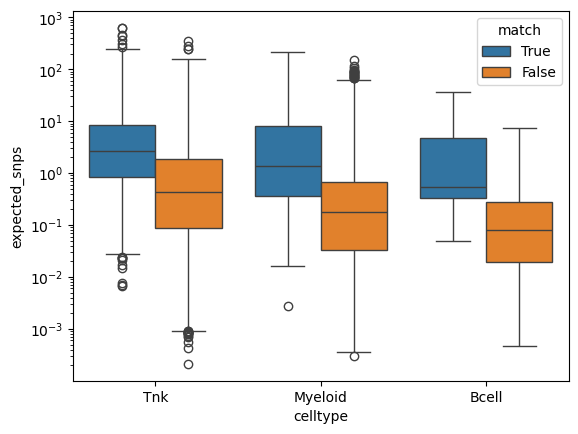

In [65]:
scent_uniques.match = scent_uniques.match.astype(str)
sns.boxplot(data=scent_uniques, x="celltype", y="expected_snps", hue="match", log_scale=True)

In [80]:
# For genes with matches vs genes without matches, what's the pli /louef scores?
match_by_genes = onek1k_scent.groupby(["celltype", "GENE"])["match"].any().reset_index()
match_by_genes = match_by_genes.merge(pli_scores, how="left", left_on="GENE", right_on="gene")
match_by_genes

,celltype,GENE,match,louef,pli,gene
0,Bcell,ACAD10,False,1.08,0.00,ACAD10
1,Bcell,ACBD4,False,0.93,0.00,ACBD4
2,Bcell,ACSL1,False,0.48,0.00,ACSL1
3,Bcell,ADAMTS6,False,0.22,1.00,ADAMTS6
4,Bcell,AGPAT2,False,1.54,0.00,AGPAT2
...,...,...,...,...,...,...
2506,Tnk,ZNF627,False,1.09,0.33,ZNF627
2507,Tnk,ZNF718,False,NaN,NaN,NaN
2508,Tnk,ZNF800,False,0.16,1.00,ZNF800
2509,Tnk,ZNFX1,False,0.25,1.00,ZNFX1


In [86]:
myeloid_table = np.array([
    [270, 625-270], 
    [69421-270, 92548-69421-270]
])
b_table = np.array([
    [50, 71-50], 
    [23794-50, 40281-23794-50]
])
t_table = np.array([
    [1040, 1801-1040], 
    [230186-1040, 295156-230186-1040]
])
fisher_exact(myeloid_table), fisher_exact(b_table), fisher_exact(t_table)

(SignificanceResult(statistic=0.251394733020471, pvalue=3.9349922903309296e-64),
 SignificanceResult(statistic=1.6482359453215247, pvalue=0.053824795993343985),
 SignificanceResult(statistic=0.38127743769120087, pvalue=4.473403833030189e-83))

<Axes: xlabel='celltype', ylabel='louef'>

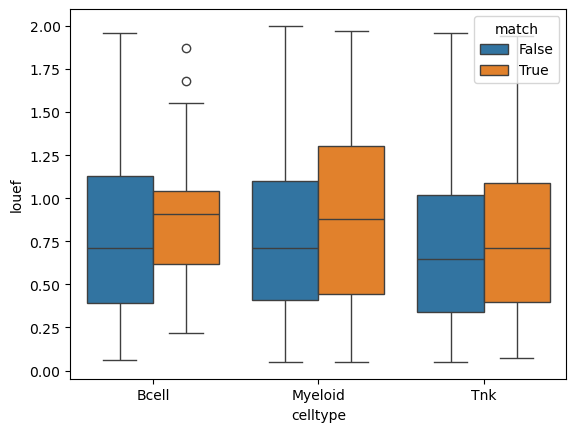

In [81]:
sns.boxplot(data=match_by_genes, x="celltype", y="louef", hue="match")

/home/bosheny/miniforge3/envs/data-science/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/bosheny/miniforge3/envs/data-science/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


<Axes: xlabel='celltype', ylabel='pli'>

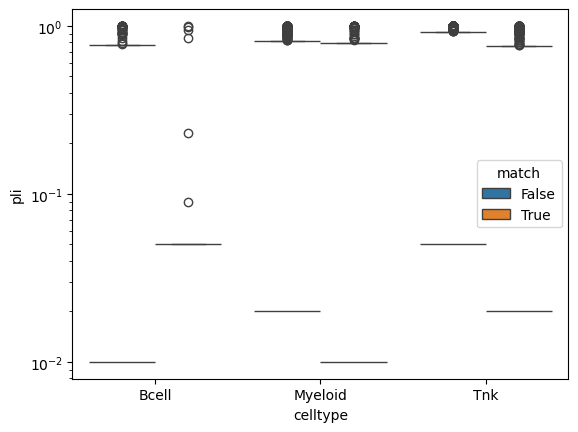

In [83]:
sns.boxplot(data=match_by_genes, x="celltype", y="pli", hue="match", log_scale=True)

In [ ]:
sns.boxplot(data=scent_uniques, x="celltype", y="expected_snps", hue="match", log_scale=True)

In [62]:
scent_uniques.value_counts(["celltype", "match"])

celltype  match
Tnk       False    4338
Myeloid   False    1981
Tnk       True      833
Bcell     False     291
Myeloid   True      246
Bcell     True       32
Name: count, dtype: int64

In [ ]:
scent["num_match_pairs"] = scent.apply(lambda x:get_num_matched_snps(x, onek1k_1), axis=1)
print((scent["num_match_pairs"] > 0).sum(), scent["num_match_pairs"].sum())
onek1k_mult = onek1k_1[onek1k_1["dup_count"] > 1]
scent["num_match_pairs_mult"] = scent.apply(lambda x:get_num_matched_snps(x, onek1k_mult), axis=1)
scent.to_csv("scent_pair_match_results.csv")


In [94]:
scent.to_csv("scent_pair_match_results.csv")

,gene,peak,beta,se,z,p,boot_p,fdr,celltype,chr,pos_start,pos_end,pairs
0,ABL2,chr1-178867358-178867980,0.810490,0.193249,4.194015,2.740598e-05,0.00004,0.016217,Bcell,chr1,178867358,178867980,ABL2-chr1-178867358-178867980
1,ABLIM1,chr10-114540798-114541777,0.715291,0.110496,6.473457,9.578577e-11,0.00004,0.016217,Bcell,chr10,114540798,114541777,ABLIM1-chr10-114540798-114541777
2,ABR,chr17-1576741-1577977,0.465925,0.114801,4.058540,4.938037e-05,0.00012,0.038722,Bcell,chr17,1576741,1577977,ABR-chr17-1576741-1577977
3,ABT1,chr6-26607255-26607921,1.011734,0.279898,3.614655,3.007477e-04,0.00004,0.016217,Bcell,chr6,26607255,26607921,ABT1-chr6-26607255-26607921
4,ACAD10,chr12-112075309-112076176,0.937681,0.230274,4.072029,4.660535e-05,0.00008,0.028125,Bcell,chr12,112075309,112076176,ACAD10-chr12-112075309-112076176
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16569,ZSWIM6,chr5-60943494-60944082,0.119328,0.021409,5.573621,2.494979e-08,0.00112,0.059858,Myeloid,chr5,60943494,60944082,ZSWIM6-chr5-60943494-60944082
16570,ZSWIM6,chr5-61341984-61342536,0.182571,0.027120,6.731941,1.674150e-11,0.00012,0.011692,Myeloid,chr5,61341984,61342536,ZSWIM6-chr5-61341984-61342536
16571,ZZEF1,chr17-3720012-3720728,0.174540,0.051049,3.419049,6.284035e-04,0.00168,0.076966,Myeloid,chr17,3720012,3720728,ZZEF1-chr17-3720012-3720728
16572,ZZEF1,chr17-3913851-3914611,0.155127,0.043049,3.603474,3.139924e-04,0.00060,0.038451,Myeloid,chr17,3913851,3914611,ZZEF1-chr17-3913851-3914611


In [74]:
same_celltype = np.array(onek1k_merged1['matched_celltype'])[:,np.newaxis] == np.array(scent['celltype'])
same_gene = np.array(onek1k_merged1['Gene ID'])[:,np.newaxis] == np.array(scent['gene'])
same_chrom = np.array(onek1k_merged1['chr'])[:,np.newaxis] == np.array(scent['chr'])
snp_after_peak_start = np.array(onek1k_merged1['pos_start'])[:,np.newaxis] >= np.array(scent['pos_start'].astype(int))
snp_before_peak_end = np.array(onek1k_merged1['pos_start'])[:,np.newaxis] <= np.array(scent['pos_end'].astype(int))

In [75]:
match_pairs_mat = same_celltype & same_gene & same_chrom & snp_after_peak_start & snp_before_peak_end

In [76]:
match_pairs_mat.sum(), (match_pairs_mat.sum(axis=0) > 0).sum(), (match_pairs_mat.sum(axis=1) > 0).sum()

(np.int64(132), np.int64(122), np.int64(132))

In [77]:
np.save("matched_pairs_matrix_onek1k_scent.npy", match_pairs_mat)

In [91]:
len(match_pairs_mat.sum(axis=1))

23386

## sanity check 

In [73]:
match_pairs_chrom_mat = same_celltype & same_gene & same_chrom
match_pairs_chrom_mat.sum(), (match_pairs_chrom_mat.sum(axis=0) > 0).sum(), (match_pairs_chrom_mat.sum(axis=1) > 0).sum()

(np.int64(17365), np.int64(5813), np.int64(4713))

### Hypothesis: eQTLs are often specific to more granular cell types

In [88]:
_onek1k = pd.read_csv("../onek1k/onek1k.tsv.gz", sep="\t", compression="gzip", index_col=0)
_onek1k["matched_celltype"] = np.select(
    [
        _onek1k["Cell type"].isin(["CD4 NC", "CD4 ET", "CD8 NC", "CD8 ET", "CD8 S100B", "CD4 SOX4", "NK", "NK R"]),
        _onek1k["Cell type"].isin(["B IN", "B Mem", "Plasma"]),
        _onek1k["Cell type"].isin(["Mono C", "Mono NC", "DC"])
    ],
    [
        "Tnk",
        "Bcell",
        "Myeloid",
    ],
    default="None"
)
onek1k_dups = _onek1k.duplicated(subset=["region", "chr", "start", "gene", "Gene ID", "matched_celltype", "SNP", "SNP assessed allele"])
onek1k_dups = _onek1k.loc[onek1k_dups].drop_duplicates(subset=["chr", "start", "Gene ID", "matched_celltype"])

In [92]:
onek1k_matched_subset = onek1k_merged1.loc[np.where(match_pairs_mat.sum(axis=1))]
onek1k_matched_subset

,index,region,chr,start,gene,pvalue,Cell type,Gene ID,Gene Ensembl ID,SNP,Chromosome,Position,SNP assessed allele,eSNP rank,rho correlation coefficient,S-statistics,qvalue,FDR,matched_celltype,hg38_chr,pos_start,pos_end,pairs
108,109,chr12:66187097,chr12,66187097.0,ENSG00000090376,2.810000e-10,B IN,IRAK3,ENSG00000090376,rs2701652,chr12,66580877,G,eSNP1,-0.200,1.893223e+08,5.096000e-07,1.545000e-05,Bcell,chr12,66187097.0,66187098.0,IRAK3-rs2701652
1275,1276,chr3:122066784,chr3,122066784.0,ENSG00000114013,6.925000e-12,B IN,CD86,ENSG00000114013,rs2681411,chr3,121785631,A,eSNP2,0.217,1.236485e+08,3.228000e-08,1.848000e-05,Bcell,chr3,122066784.0,122066785.0,CD86-rs2681411
1654,1655,chr5:181051190,chr5,181051190.0,ENSG00000165810,1.672000e-12,B IN,BTNL9,ENSG00000165810,rs9686314,chr5,180478190,G,eSNP4,0.223,1.226755e+08,6.022000e-12,1.279000e-07,Bcell,chr5,181051190.0,181051191.0,BTNL9-rs9686314
1931,1932,chr12:10723460,chr12,10723460.0,ENSG00000060138,4.731000e-07,B Mem,YBX3,ENSG00000060138,rs12317203,chr12,10876059,T,eSNP1,-0.160,1.830646e+08,7.404000e-04,6.992000e-03,Bcell,chr12,10723460.0,10723461.0,YBX3-rs12317203
3291,3292,chr11:61026250,chr11,61026250.0,ENSG00000013725,1.720000e-22,CD4 NC,CD6,ENSG00000013725,rs4939491,chr11,60793722,A,eSNP1,-0.304,2.058599e+08,1.322000e-19,2.211000e-06,Tnk,chr11,61026250.0,61026251.0,CD6-rs4939491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22163,22164,chr21:46142718,chr21,46142718.0,ENSG00000160299,3.874000e-04,NK,PCNT,ENSG00000160299,rs4819206,chr21,47562632,C,eSNP2,-0.113,1.756650e+08,4.136000e-03,1.353000e-02,Tnk,chr21,46142718.0,46142719.0,PCNT-rs4819206
22178,22179,chr22:43171539,chr22,43171539.0,ENSG00000100300,3.348000e-04,NK,TSPO,ENSG00000100300,rs2071728,chr22,43567545,A,eSNP2,-0.114,1.758560e+08,2.445000e-03,3.974000e-02,Tnk,chr22,43171539.0,43171540.0,TSPO-rs2071728
22287,22288,chr5:39287804,chr5,39287804.0,ENSG00000082074,4.834000e-05,NK,FYB,ENSG00000082074,rs575551,chr5,39287906,C,eSNP2,0.129,1.374217e+08,7.533000e-04,4.446000e-03,Tnk,chr5,39287804.0,39287805.0,FYB-rs575551
22510,22511,chr17:46290846,chr17,46290846.0,ENSG00000262372,6.598000e-14,NK,RP11-669E14.6,ENSG00000262372,rs2957297,chr17,44368212,A,eSNP3,-0.236,1.950916e+08,3.403000e-12,9.767000e-08,Tnk,chr17,46290846.0,46290847.0,RP11-669E14.6-rs2957297


In [93]:
onek1k_dups.merge(onek1k_matched_subset, how='inner', on=["chr", "start", "Gene ID", "matched_celltype"])

,region_x,chr,start,gene_x,pvalue_x,Cell type_x,Gene ID,Gene Ensembl ID_x,SNP_x,Chromosome_x,Position_x,SNP assessed allele_x,eSNP rank_x,rho correlation coefficient_x,S-statistics_x,qvalue_x,FDR_x,matched_celltype,index,region_y,gene_y,pvalue_y,Cell type_y,Gene Ensembl ID_y,SNP_y,Chromosome_y,Position_y,SNP assessed allele_y,eSNP rank_y,rho correlation coefficient_y,S-statistics_y,qvalue_y,FDR_y,hg38_chr,pos_start,pos_end,pairs
0,chr12:44847987,chr12,44847987.0,ENSG00000184613,9.498000e-08,CD4 ET,NELL2,ENSG00000184613,rs2658954,chr12,45241770,A,eSNP1,0.169,1.311126e+08,9.576000e-05,8.599000e-04,Tnk,3495,chr12:44847987,ENSG00000184613,1.675000e-28,CD4 NC,ENSG00000184613,rs2658954,chr12,45241770,A,eSNP1,0.343,1.036852e+08,3.289000e-25,2.555000e-06,chr12,44847987.0,44847988.0,NELL2-rs2658954
1,chr16:1964833,chr16,1964833.0,ENSG00000140988,2.181000e-37,CD4 ET,RPS2,ENSG00000140988,rs17135718,chr16,2014834,G,eSNP1,0.392,9.598473e+07,3.746000e-33,1.336000e-05,Tnk,4070,chr16:1964833,ENSG00000140988,2.614000e-49,CD4 NC,ENSG00000140988,rs17135718,chr16,2014834,G,eSNP1,0.447,8.734363e+07,1.113000e-45,3.430000e-06,chr16,1964833.0,1964834.0,RPS2-rs17135718
2,chr19:55385959,chr19,55385959.0,ENSG00000108107,9.649000e-168,CD4 ET,RPL28,ENSG00000108107,rs17700376,chr19,55897327,G,eSNP1,-0.735,2.738776e+08,3.642000e-161,1.759000e-05,Tnk,4580,chr19:55385959,ENSG00000108107,1.615000e-201,CD4 NC,ENSG00000108107,rs17700376,chr19,55897327,G,eSNP1,-0.780,2.808955e+08,2.557000e-195,3.505000e-06,chr19,55385959.0,55385960.0,RPL28-rs17700376
3,chr19:543497,chr19,543497.0,ENSG00000197540,2.543000e-10,CD4 ET,GZMM,ENSG00000197540,rs16990714,chr19,543497,T,eSNP1,-0.200,1.893977e+08,5.758000e-07,1.759000e-05,Tnk,4641,chr19:543497,ENSG00000197540,3.857000e-19,CD4 NC,ENSG00000197540,rs16990714,chr19,543497,T,eSNP1,-0.280,2.020115e+08,4.980000e-16,3.505000e-06,chr19,543497.0,543498.0,GZMM-rs16990714
4,chr21:46622601,chr21,46622601.0,ENSG00000160310,9.927000e-27,CD4 ET,PRMT2,ENSG00000160310,rs11910707,chr21,48042513,T,eSNP1,0.332,1.053970e+08,1.687000e-23,4.282000e-06,Tnk,5394,chr21:46622601,ENSG00000160310,3.905000e-67,CD4 NC,ENSG00000160310,rs11910707,chr21,48042513,T,eSNP1,0.513,7.680173e+07,8.700000e-64,1.601000e-06,chr21,46622601.0,46622602.0,PRMT2-rs11910707
5,chr2:241111131,chr2,241111131.0,ENSG00000115687,1.177000e-43,CD4 ET,PASK,ENSG00000115687,rs3815296,chr2,242050546,G,eSNP1,-0.422,2.244116e+08,6.875000e-40,6.171000e-06,Tnk,5597,chr2:241111131,ENSG00000115687,2.568000e-82,CD4 NC,ENSG00000115687,rs3815296,chr2,242050546,G,eSNP1,-0.560,2.462881e+08,9.159000e-79,1.737000e-06,chr2,241111131.0,241111132.0,PASK-rs3815296
6,chr4:142704109,chr4,142704109.0,ENSG00000109452,1.556000e-06,CD4 ET,INPP4B,ENSG00000109452,rs1373036,chr4,143625262,A,eSNP1,0.153,1.337442e+08,7.752000e-04,9.546000e-03,Tnk,6154,chr4:142704109,ENSG00000109452,5.329000e-23,CD4 NC,ENSG00000109452,rs1373036,chr4,143625262,A,eSNP1,0.308,1.092418e+08,3.654000e-20,2.139000e-06,chr4,142704109.0,142704110.0,INPP4B-rs1373036
7,chr5:56148856,chr5,56148856.0,ENSG00000164512,5.260000e-12,CD4 ET,ANKRD55,ENSG00000164512,rs7731626,chr5,55444683,A,eSNP1,-0.218,1.921970e+08,6.317000e-09,9.035000e-06,Tnk,6281,chr5:56148856,ENSG00000164512,1.531000e-58,CD4 NC,ENSG00000164512,rs7731626,chr5,55444683,A,eSNP1,-0.483,2.340613e+08,4.420000e-55,2.619000e-06,chr5,56148856.0,56148857.0,ANKRD55-rs7731626
8,chr5:147782912,chr5,147782912.0,ENSG00000176049,1.897000e-10,CD4 ET,JAKMIP2,ENSG00000176049,rs2436340,chr5,147162475,A,eSNP1,0.201,1.260367e+08,1.840000e-07,9.035000e-06,Tnk,6283,chr5:147782912,ENSG00000176049,3.346000e-55,CD4 NC,ENSG00000176049,rs2436340,chr5,147162475,A,eSNP1,0.470,8.359430e+07,8.462000e-52,2.619000e-06,chr5,147782912.0,147782913.0,JAKMIP2-rs2436340
9,chr5:111230662,chr5,111230662.0,ENSG00000152495,4.658000e-09,CD4 ET,CAMK4,ENSG00000152495,rs114378220,chr5,110566360,T,eSNP1,-0.186,1.871167e+08,3.908000e-06,9.035000e-06,Tnk,6304,chr5:111230662,ENSG00000152495,3.571000e-23,CD4 NC,ENSG00000152495,rs

In [96]:
_onek1k.shape

(26597, 18)

In [95]:
_onek1k.FDR.max()

np.float64(0.04999)